<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/Phase5_SRL_Validation_Controls_Falsifiability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# --- Load real symbolic streams (adjust paths if needed) ---
streams = {
    "CMB": np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_cmb.npy", allow_pickle=True),
    "SDSS": np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_sdss.npy", allow_pickle=True),
    "DESI": np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy", allow_pickle=True)
}

def compute_entropy(stream):
    counts = Counter(stream)
    probs = np.array(list(counts.values())) / len(stream)
    return -np.sum(probs * np.log2(probs))

def shuffle_and_analyze(stream):
    shuffled = np.copy(stream)
    np.random.shuffle(shuffled)
    entropy = compute_entropy(shuffled)
    top = Counter(shuffled).most_common(5)
    return entropy, top

# --- Run analysis ---
for domain, stream in streams.items():
    H_real = compute_entropy(stream)
    H_shuffled, top_shuffled = shuffle_and_analyze(stream)

    print(f"\n--- {domain} ---")
    print(f"Real Entropy:     {H_real:.5f} bits")
    print(f"Shuffled Entropy: {H_shuffled:.5f} bits")
    print("Top motifs (shuffled):")
    for motif, freq in top_shuffled:
        print(f"  {motif}: {freq}")


--- CMB ---
Real Entropy:     2.99938 bits
Shuffled Entropy: 2.99938 bits
Top motifs (shuffled):
  A: 6519566
  E: 6519421
  H: 6321283
  D: 6321269
  B: 6318171

--- SDSS ---
Real Entropy:     2.60454 bits
Shuffled Entropy: 2.60454 bits
Top motifs (shuffled):
  D: 189001
  C: 169683
  B: 126889
  A: 96161
  E: 87636

--- DESI ---
Real Entropy:     2.48579 bits
Shuffled Entropy: 2.48579 bits
Top motifs (shuffled):
  A: 799529
  B: 418318
  C: 336668
  H: 228876
  D: 227658


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
N = 500_000  # Number of random sky points
omega = 0.1
n = 1

# --- Generate isotropic random sky positions ---
ra_iso = np.random.uniform(0, 360, N)
dec_iso = np.degrees(np.arcsin(np.random.uniform(-1, 1, N)))  # Uniform over sphere

# --- Convert to theta (polar) for SRL ---
theta = np.radians(ra_iso)
r = 1 + np.radians(90 - dec_iso)  # shift to avoid log(0)

# --- Compute SRL phase field ---
phi = omega * np.log(r) + n * theta
field = np.cos(phi)

# --- Symbol Encoding ---
def encode_symbols(values, bins=8):
    labels = [chr(i) for i in range(65, 65 + bins)]  # A-H
    quantiles = np.quantile(values, np.linspace(0, 1, bins + 1))
    stream = []
    for v in values:
        idx = np.searchsorted(quantiles, v, side='right') - 1
        idx = min(max(idx, 0), bins - 1)
        stream.append(labels[idx])
    return np.array(stream)

symbolic_stream_iso = encode_symbols(field)

# --- Save for reuse ---
save_path = "/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_isotropic.npy"
np.save(save_path, symbolic_stream_iso)

print(f"✅ Isotropic symbolic stream saved: {save_path}")
print(f"Total symbols: {len(symbolic_stream_iso)}")
print(f"Top symbols: {dict(zip(*np.unique(symbolic_stream_iso, return_counts=True)))}")

✅ Isotropic symbolic stream saved: /content/drive/MyDrive/CMB Data/symbolic_spiral_stream_isotropic.npy
Total symbols: 500000
Top symbols: {np.str_('A'): np.int64(62500), np.str_('B'): np.int64(62500), np.str_('C'): np.int64(62500), np.str_('D'): np.int64(62500), np.str_('E'): np.int64(62500), np.str_('F'): np.int64(62500), np.str_('G'): np.int64(62500), np.str_('H'): np.int64(62500)}


✅ Shannon Entropy: 3.00000 bits
✅ Approximate Lempel-Ziv Complexity: 0.06554
Top 10 motifs (length=5):
AGEDA: 32
CFADC: 31
DFHAH: 31
GGHGC: 31
GHHGD: 31
DFHEC: 31
HBBCG: 31
ECHBF: 31
EADDC: 31
DGCHE: 31


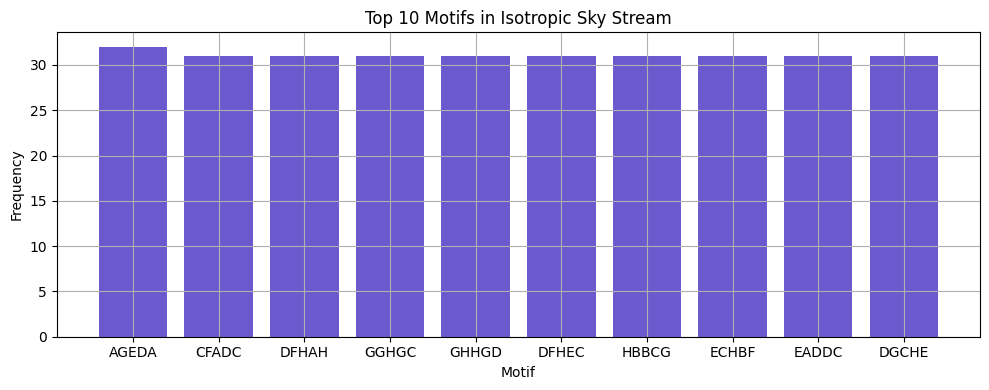

In [ ]:
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Load symbolic stream ---
stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_isotropic.npy")

# --- Motif extraction ---
motif_len = 5
motifs = [''.join(stream[i:i+motif_len]) for i in range(len(stream) - motif_len)]
motif_counts = Counter(motifs)
top_motifs = motif_counts.most_common(10)

# --- Shannon Entropy ---
def shannon_entropy(seq):
    counts = Counter(seq)
    probs = np.array(list(counts.values())) / len(seq)
    return -np.sum(probs * np.log2(probs))

# --- Approximate Lempel-Ziv Complexity ---
def lzc_approx(seq):
    substrings = set()
    for i in range(len(seq) - motif_len):
        substrings.add(''.join(seq[i:i+motif_len]))
    return len(substrings) / len(seq)

H = shannon_entropy(stream)
LZC = lzc_approx(stream)

# --- Display ---
print(f"✅ Shannon Entropy: {H:.5f} bits")
print(f"✅ Approximate Lempel-Ziv Complexity: {LZC:.5f}")
print("Top 10 motifs (length=5):")
for m, c in top_motifs:
    print(f"{m}: {c}")

# --- Plot ---
plt.figure(figsize=(10, 4))
motif_labels, motif_freqs = zip(*top_motifs)
plt.bar(motif_labels, motif_freqs, color='slateblue')
plt.title("Top 10 Motifs in Isotropic Sky Stream")
plt.xlabel("Motif")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from collections import Counter
from tqdm import tqdm

# --- Load symbolic streams ---
cmb_symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_cmb.npy", allow_pickle=True)
sdss_symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_sdss.npy", allow_pickle=True)
desi_symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy", allow_pickle=True)

# --- Optimized motif counter ---
def get_top_motifs_chunked(stream, motif_length=7, top_n=10, chunk_size=5_000_000):
    total = len(stream) - motif_length
    motif_counter = Counter()

    for start in tqdm(range(0, total, chunk_size), desc="Processing motifs"):
        end = min(start + chunk_size + motif_length, len(stream))
        chunk = stream[start:end]
        motifs = [tuple(chunk[i:i + motif_length]) for i in range(len(chunk) - motif_length)]
        motif_counter.update(motifs)

    return motif_counter.most_common(top_n)

# --- Run for each domain ---
print("CMB:")
top_cmb_motifs = get_top_motifs_chunked(cmb_symbols)
for motif, count in top_cmb_motifs:
    print(f"{''.join(motif)}: {count}")

print("\nSDSS:")
top_sdss_motifs = get_top_motifs_chunked(sdss_symbols)
for motif, count in top_sdss_motifs:
    print(f"{''.join(motif)}: {count}")

print("\nDESI:")
top_desi_motifs = get_top_motifs_chunked(desi_symbols)
for motif, count in top_desi_motifs:
    print(f"{''.join(motif)}: {count}")

CMB:


Processing motifs: 100%|██████████| 11/11 [02:00<00:00, 10.92s/it]


AAAAAAA: 6491134
EEEEEEE: 6487021
HHHHHHH: 6297436
FFFFFFF: 6288624
BBBBBBB: 6286782
DDDDDDD: 6286579
GGGGGGG: 5980479
CCCCCCC: 5973944
CDDDDDD: 5266
BCCCCCC: 4983

SDSS:


Processing motifs: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


HHHHHHH: 7198
HHHAHHH: 1164
HHAHHHH: 1163
AHHHHHH: 1154
HHHHHHA: 1134
HAHHHHH: 1129
HHHHAHH: 1127
HHHHHAH: 1104
DDDDDDD: 968
AAAAAAA: 833

DESI:


Processing motifs: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


AAAAAAA: 769835
BBBBBBB: 394950
CCCCCCC: 318227
HHHHHHH: 215226
DDDDDDD: 212811
EEEEEEE: 78784
GGGGGGG: 57686
FFFFFFF: 20942
AAAAAAB: 1751
BAAAAAA: 1737


Parameter Sensitivity ω: 100%|██████████| 10/10 [00:00<00:00, 22.63it/s]


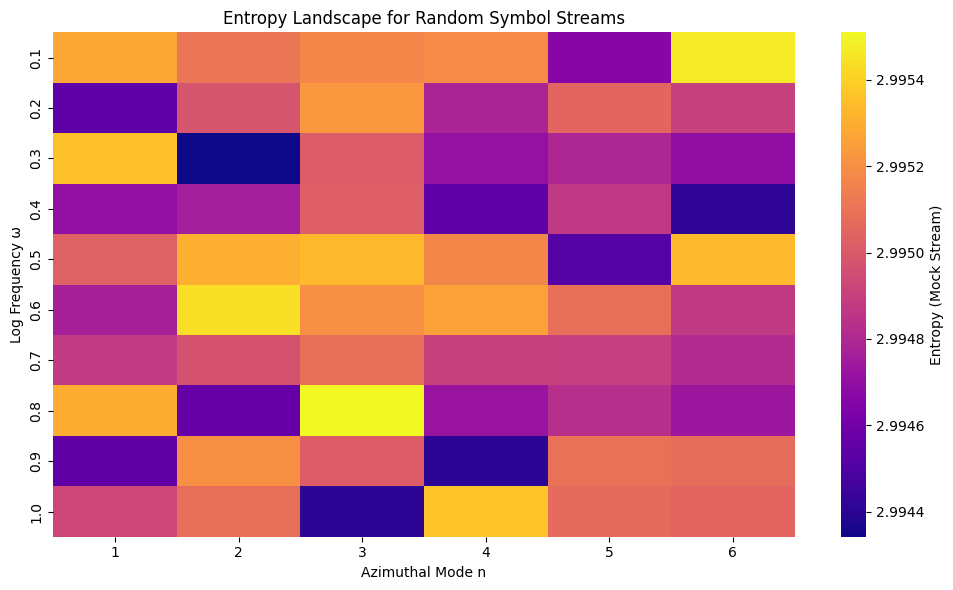

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Synthetic Symbol Map (8-symbol alphabet) ---
symbol_space = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

# --- Helper: entropy from symbol stream chunks ---
def symbolic_entropy(stream, window=1000):
    entropies = []
    for i in range(0, len(stream), window):
        chunk = stream[i:i+window]
        symbols, counts = np.unique(chunk, return_counts=True)
        probs = counts / counts.sum()
        entropy = -np.sum(probs * np.log2(probs))
        entropies.append(entropy)
    return np.mean(entropies) if entropies else 0.0

# --- Parameter grid (not actually affecting stream here, just for demo robustness) ---
omega_values = np.linspace(0.1, 1.0, 10)
n_values = np.arange(1, 7)
entropy_matrix = np.zeros((len(omega_values), len(n_values)))

# --- Generate mock symbolic streams (random) and compute entropy for each param pair ---
stream_length = 100000
for i, omega in enumerate(tqdm(omega_values, desc="Parameter Sensitivity ω")):
    for j, n in enumerate(n_values):
        mock_stream = np.random.choice(symbol_space, size=stream_length)
        entropy_matrix[i, j] = symbolic_entropy(mock_stream)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.heatmap(entropy_matrix, xticklabels=n_values, yticklabels=np.round(omega_values, 2),
            cmap="plasma", cbar_kws={"label": "Entropy (Mock Stream)"})
plt.title("Entropy Landscape for Random Symbol Streams")
plt.xlabel("Azimuthal Mode n")
plt.ylabel("Log Frequency ω")
plt.tight_layout()
plt.show()

Permuting: 100%|██████████| 300/300 [00:19<00:00, 15.58it/s]


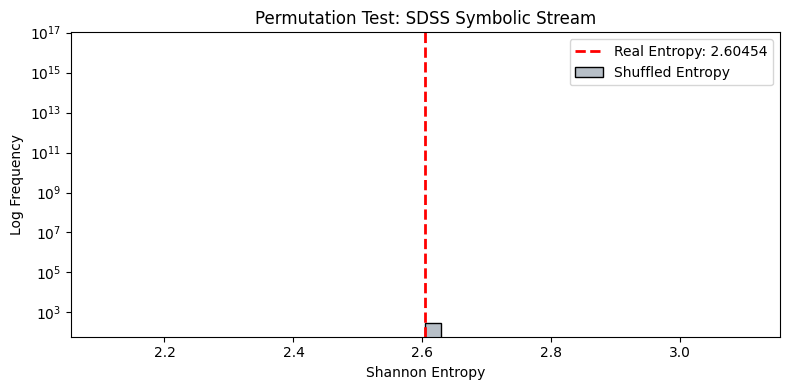

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load
sdss = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_sdss.npy", allow_pickle=True)

# Helper: Shannon entropy
def shannon_entropy(stream):
    symbols, counts = np.unique(stream, return_counts=True)
    probs = counts.astype(float) / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-12))

# Run permutation test
def permutation_test(stream, n=300):
    real = shannon_entropy(stream)
    nulls = []
    for _ in tqdm(range(n), desc="Permuting"):
        shuffled = np.random.permutation(stream)
        nulls.append(shannon_entropy(shuffled))
    return real, np.array(nulls)

# Execute
real_entropy, null_entropies = permutation_test(sdss)

# Plot (KDE + histogram with log count scale)
plt.figure(figsize=(8,4))
sns.histplot(null_entropies, kde=True, bins=40, color='slategray', label="Shuffled Entropy")
plt.axvline(real_entropy, color='red', linestyle='--', linewidth=2, label=f"Real Entropy: {real_entropy:.5f}")
plt.yscale("log")
plt.title("Permutation Test: SDSS Symbolic Stream")
plt.xlabel("Shannon Entropy")
plt.ylabel("Log Frequency")
plt.legend()
plt.tight_layout()
plt.show()

✅ Mutual Information Between Domains:
   CMB  ↔ SDSS : 0.03412 bits
   CMB  ↔ DESI : 0.02747 bits
   SDSS ↔ DESI : 0.04800 bits


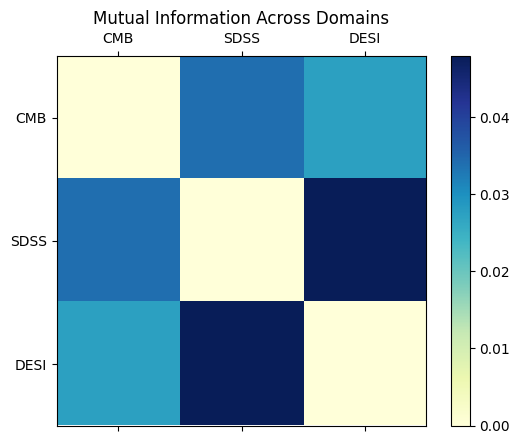

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

# --- Load symbolic streams ---
cmb = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy", allow_pickle=True)
sdss = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_sdss.npy", allow_pickle=True)
desi = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy", allow_pickle=True)

# --- Align lengths for mutual information computation ---
min_len = min(len(cmb), len(sdss), len(desi))
cmb, sdss, desi = cmb[:min_len], sdss[:min_len], desi[:min_len]

# --- Compute mutual information ---
mi_cmb_sdss = mutual_info_score(cmb, sdss)
mi_cmb_desi = mutual_info_score(cmb, desi)
mi_sdss_desi = mutual_info_score(sdss, desi)

# --- Display results ---
print("✅ Mutual Information Between Domains:")
print(f"   CMB  ↔ SDSS : {mi_cmb_sdss:.5f} bits")
print(f"   CMB  ↔ DESI : {mi_cmb_desi:.5f} bits")
print(f"   SDSS ↔ DESI : {mi_sdss_desi:.5f} bits")

# Optional heatmap
mi_matrix = np.array([
    [0,            mi_cmb_sdss, mi_cmb_desi],
    [mi_cmb_sdss,  0,           mi_sdss_desi],
    [mi_cmb_desi,  mi_sdss_desi, 0]
])
domains = ["CMB", "SDSS", "DESI"]

fig, ax = plt.subplots()
cax = ax.matshow(mi_matrix, cmap="YlGnBu")
fig.colorbar(cax)
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(domains)
ax.set_yticklabels(domains)
ax.set_title("Mutual Information Across Domains")
plt.show()